<a href="https://colab.research.google.com/github/manthan2305/leetcode-questions-analysis/blob/main/notebooks/topic_prediction_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Questions topic classification using BERT

#### Initial checks

In [1]:
!nvidia-smi

Tue Apr 26 10:20:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/manthan2305/leetcode-questions-analysis.git

Cloning into 'leetcode-questions-analysis'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 91 (delta 40), reused 83 (delta 35), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
! pip install -q pytorch-lightning

! pip install -q bs4
! pip install -q transformers

     |████████████████████████████████| 582 kB 5.5 MB/s 
     |████████████████████████████████| 408 kB 10.0 MB/s 
     |████████████████████████████████| 136 kB 30.7 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
     |████████████████████████████████| 1.1 MB 27.3 MB/s 
     |████████████████████████████████| 144 kB 42.5 MB/s 
     |████████████████████████████████| 271 kB 34.5 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 41.4 MB/s 
     |████████████████████████████████| 6.6 MB 35.6 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 


In [4]:
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data = pd.read_csv('/content/leetcode-questions-analysis/data/all_questions_data.csv')

### Process Data

In [6]:
data = data[['Question ID', 'Question Title', 'Question Text', 'Topic Tagged text']]
data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [7]:
# preprocess data
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [8]:
data['Question Title'] = data['Question Title'].apply(pre_process)
data['Question Text'] = data['Question Text'].apply(pre_process)

In [9]:
data['text'] = data['Question Title'] + data['Question Text'] 

### Work on top - 10 Labels

In [10]:
# Total number of quetions in each topics

# Generate questions stats
topics_count = {}

for _, que in data[['Topic Tagged text']].iterrows():
    
    if type(que['Topic Tagged text']) != str:
        continue
        
    topics_lst = que['Topic Tagged text'].split(',')
    
    for topic in topics_lst:
        # Topic count
        if topic not in list(topics_count.keys()):
            topics_count[topic] = 1
        else:
            topics_count[topic] = topics_count[topic] + 1

# create dataframe
tc_df = pd.DataFrame(pd.Series(topics_count)).reset_index()
tc_df.columns = ['Topics', 'Total Questions']
tc_df.sort_values(by=['Total Questions'], ascending=False, inplace=True)
tc_df.reset_index(drop=True, inplace=True)

In [11]:
# first 10 labels

labels = list(tc_df[:10]['Topics'])
main_labels = labels
labels

['Array',
 'String',
 'Dynamic Programming',
 'Math',
 'Hash Table',
 'Sorting',
 'Greedy',
 'Depth-First Search',
 'Breadth-First Search',
 'Binary Search']

In [12]:

df = pd.DataFrame()

for _, row in data.iterrows():
    q_dict = {}
    q_dict['id'] = row['Question ID']
    q_dict['text'] = row['text']
    
    row_labels = row['Topic Tagged text'].split(',')
    

    # filter question who has labels from target labels
    if any(label in row_labels for label in main_labels):
        label_lst = []
        for label in row_labels:
          if label in main_labels:
            label_lst.append(label)

        q_dict['topics'] = label_lst
        q_df = pd.DataFrame.from_dict(q_dict, orient='index').transpose()
        df = df.append(q_df)
    
df.reset_index(drop=True, inplace=True)

In [13]:
df

,id,text,topics
0,1977,minimum interval to include each queryyou are ...,"[Array, Binary Search, Sorting]"
1,1983,maximum population yearyou are given a d integ...,[Array]
2,1984,maximum distance between a pair of valuesyou a...,"[Array, Binary Search, Greedy]"
3,1985,maximum subarray min productthe min product of...,[Array]
4,1986,largest color value in a directed graphthere i...,"[Hash Table, Dynamic Programming]"
...,...,...,...
1622,876,hand of straightsalice has some number of card...,"[Array, Hash Table, Greedy, Sorting]"
1623,877,shortest path visiting all nodesyou have an un...,"[Dynamic Programming, Breadth-First Search]"
1624,878,shifting lettersyou are given a string s of lo...,"[Array, String]"
1625,879,maximize distance to closest personyou are giv...,[Array]


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

yt = mlb.fit_transform(df['topics'])
yt.shape

(1627, 10)

In [15]:
# check how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
# print(mlb.classes_)

[1 1 0 0 0 0 0 0 1 0]
[('Array', 'Binary Search', 'Sorting')]


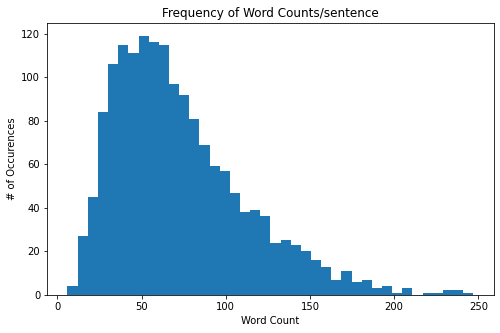

In [16]:
# compute no. of words in each question
questions = list(df['text'])
word_cnt = [len(quest.split()) for quest in questions]
# Plot 
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

In [17]:
# Split into train, val, test
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(list(df['text']), yt, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [18]:
len(x_tr), len(x_val), len(x_test)

(1171, 293, 163)

#### Prepare Dataset and Data Module

In [19]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [20]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)


In [21]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
max_word_cnt = 300
quest_cnt = 0

# For every sentence...
for question in questions:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt}')

# Question having word count > 300: is  0


In [23]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 12
MAX_LEN = 300
LR = 2e-05

In [24]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()


## Train Model

In [25]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }



    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [26]:
# Instantiate the classifier model
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=10, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [28]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 7.7 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.272   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [30]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3248066306114197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3248066306114197}]

## Evaluate Model Performance on Test Set

In [31]:
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

'/content/lightning_logs/version_0/checkpoints/QTag-epoch=11-val_loss=0.33.ckpt'

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
%cp '/content/lightning_logs/version_0/checkpoints/QTag-epoch=11-val_loss=0.33.ckpt' '/content/drive/MyDrive/Colab Notebooks/leetcode/'

### Set up test datset for BERT

In [35]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

### Predictions

In [36]:
flat_pred_outs = 0
flat_true_labels = 0

In [37]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [38]:
pred_outs[0][0]

array([0.14636332, 0.09378505, 0.46871   , 0.7025939 , 0.1573957 ,
       0.0995421 , 0.18857035, 0.2091424 , 0.11447485, 0.13256635],
      dtype=float32)

In [39]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [40]:
flat_pred_outs.shape , flat_true_labels.shape

((163, 10), (163, 10))

In [41]:
#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [42]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [43]:
flat_pred_outs[3]

array([0.9669211 , 0.18217707, 0.05871101, 0.04529995, 0.23070931,
       0.209347  , 0.22018698, 0.11203419, 0.23676477, 0.03381873],
      dtype=float32)

In [44]:
flat_true_labels[3]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [45]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [46]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

Optimal Threshold Value = 0.41000000000000003


### Performance score evaluation

In [47]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [48]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1312
           1       0.87      0.48      0.62       318

    accuracy                           0.88      1630
   macro avg       0.88      0.73      0.78      1630
weighted avg       0.88      0.88      0.87      1630



In [49]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [50]:
df.sample(10)


,Body,Actual Tags,Predicted Tags
135,projection area of d shapesyou are given an n ...,"(Array, Math)","(Array,)"
115,cousins in binary treegiven the root of a bina...,"(Breadth-First Search, Depth-First Search)","(Breadth-First Search, Depth-First Search)"
131,make the xor of all segments equal to zeroyou ...,"(Array, Dynamic Programming)","(Array,)"
55,duplicate zerosgiven a fixed length integer ar...,"(Array,)","(Array,)"
95,two best non overlapping eventsyou are given a...,"(Array, Binary Search, Dynamic Programming, So...","(Array,)"
29,cut off trees for golf eventyou are asked to c...,"(Array, Breadth-First Search)","(Array,)"
156,count the hidden sequencesyou are given a inde...,"(Array,)","(Array,)"
51,substring with concatenation of all wordsyou a...,"(Hash Table, String)","(Array, String)"
101,convert sorted array to binary search treegive...,"(Array,)","(Array,)"
145,poor pigsthere are buckets buckets of liquid w...,"(Dynamic Programming, Math)","(Math,)"


## Inference

In [ ]:
# load a model along with its weights, biases and hyperparameters
QTmodel = QTagClassifier.load_from_checkpoint(model_path)
QTmodel.eval()

In [53]:
#Function to Predict Tags from a Question
def predict(question):
    text_enc = Bert_tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'      
    )
    outputs = QTmodel(text_enc['input_ids'], text_enc['attention_mask'])
    pred_out = outputs[0].detach().numpy()
    #print(f'Outputs = {outputs}')
    #print(f'Type = {type(outputs)}')
    #print(f'Pred Outputs = {pred_out}')
    #print(f'Type = {type(pred_out)}')
    #preds = np.round(pred_out)
    preds = [(pred > opt_thresh) for pred in pred_out ]
    #pred_list = [ round(pred) for pred in pred_logits ]
    preds = np.asarray(preds)
    #print(f'Predictions = {preds}')
    #print(f'Type = {type(preds)}')
    #print(mlb.classes_)
    new_preds = preds.reshape(1,-1).astype(int)
    #print(new_preds)
    pred_tags = mlb.inverse_transform(new_preds)
    #print(mlb.inverse_transform(np.array(new_preds)))
    return pred_tags 
    

In [60]:
# Question
question = """Given a string containing digits from 2-9 inclusive, return all possible letter combinations that the number could represent. Return the answer in any order.

A mapping of digit to letters (just like on the telephone buttons) is given below. Note that 1 does not map to any letters."""

# Call the predict function to predict the associated Tags
tags = predict(question)
if not tags[0]:
    print('This Question can not be associated with any known tag - Please review to see if a new tag is required ')
else:
    print(f'Following Tags are associated : \n {tags}')

Following Tags are associated : 
 [('String',)]
